In [1]:
import os
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.autograd as autograd
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import wandb

# Параметры модели и обучения

In [2]:
from dataset import ArchNegatives, ArchPositives
from train_encoder_izif import train_encoder_izif
from model_0_conv import Generator, Discriminator, Encoder

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
params = {
    'batch_size': 32,
    'channels': 3,
    'img_size': 256,
    'latent_dim': 100,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 400,
}

In [5]:
model_name = 'encoder_256'
results_dir = 'results_encoder_256'

# Датасет

In [6]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
train_dataset = ArchNegatives(transform=transform_base)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchPositives(transform=transform_base)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [8]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 4374 batches
anomalies: 163 images, 6 batches


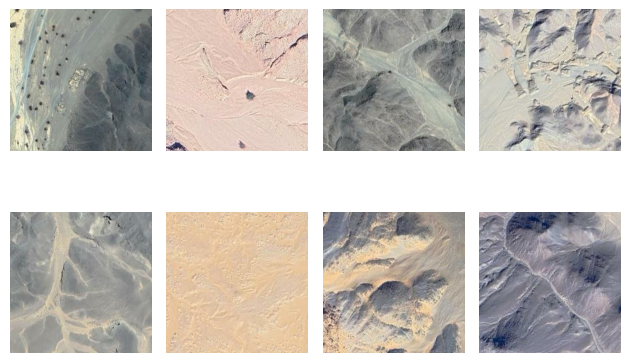

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=4)

for i in range(4):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    
    axs[0, i].imshow((anomalies_dataset[i][0].permute(1, 2, 0) + 1) / 2)
    axs[1, i].imshow((train_dataset[i][0].permute(1, 2, 0) + 1) / 2)
    
fig.tight_layout()
fig.show()

# Обучение Encoder

In [10]:
# !pip install wandb --upgrade

In [10]:
import wandb

wandb.login(key='514eb1383ebf19dfe33c9834438026c917300873')
wandb.init( project='arch_fanogan_pt2', name=f'encoder_izif_256_v3')

wandb: Currently logged in as: nadiaroschina (nadiaroschina-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: wandb version 0.17.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /home/jupyter/datasphere/archaeology-project/fanogan_training/train_izif_encoder/wandb/run-20240705_201202-jme85v92
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run encoder_izif_256_v3
wandb: ⭐️ View project at https://wandb.ai/nadiaroschina-team/arch_fanogan_pt2
wandb: 🚀 View run at https://wandb.ai/nadiaroschina-team/arch_fanogan_pt2/runs/jme85v92


In [11]:
generator = Generator(params)
discriminator = Discriminator(params)
encoder = Encoder(params)

In [12]:
generator.load_state_dict(torch.load('../train_wgan/results_conv_256/generator', map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load('../train_wgan/results_conv_256/discriminator', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
with tqdm(
    total=params['n_epochs']*len(train_loader), 
    desc=f"[Epoch ?] [Batch ?] [E loss: ?]"
) as pbar:
    train_encoder_izif(results_dir, pbar, params, generator, discriminator, encoder, train_loader, device)

[Epoch   0/200] [Batch 2990/4374] [E loss: 0.045113]:   0%|          | 599/874800 [22:07<546:45:34,  2.25s/it]

In [ ]:
# torch.save(encoder.state_dict(), f"{results_dir}/encoder")